In [ ]:
# from trainPINN import pdeTrainClass

# Physics-informed neural network

In this assignment, we will use a neural net to approximate the solution u(x) of the Helmholtz equation
$$ \Delta^2u(x)-ku(x)=f(x)$$

Forcing function and constants
$$f(x) = -(\pi^2 + 1) sin(\pi x)$$
$$k = 1$$

Boundary conditions
$$x\in [-1,1]; u(-1) = 0; u(1) = 0$$

The solution to this PDE is $u = sin(\pi x)$ (you can quickly verify this by plugging it in). We don't need that information to train the network, but just to compare the true solution with the PINN solution.
To do:
* First write the code for the initialization and training in trainPINN.py
* Determine hyperparameters that allow you to get a good match between the predicted and true solution. The hyperparemeters are filled out in this file PINN.ipynb
* Plot the MSE loss as a function of the number of epochs (pdeTrainClass.plots())
* Plot the true solution for your hyperparameters comparing with the predicted solution (pdeTrainClass.plots())
* For the number of epochs you used in the previous plot, produce another plot number of samples vs MSE loss (you will have to train a neral network for each point that populates this graph)

In [1]:
import numpy as np
import statistics 
import torch
import matplotlib.pyplot as plt
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import math
import torch.nn as nn

In [2]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)
        
class PINN(nn.Module):
    def __init__(self):
        super(PINN,self).__init__()
        #layer definitions
        self.FC = nn.ModuleDict({
            '1': nn.Linear(1,50),
            '2': nn.Linear(50,50),
            '3': nn.Linear(50,1)
            })
        self.act = nn.Tanh()

    def forward(self, x):
        x1 = self.FC['1'](x)
        x2 = self.act(x1)
        x3 = self.FC['2'](x2)
        x4 = self.act(x3)
        x5 = self.FC['3'](x4)
        u = self.act(x5)
        return u

    # loss function
    def MSE(self,ypred,ytrue):
        return torch.mean((ypred - ytrue)**2)

In [3]:
class pdeTrainClass:
    
    def __init__(self, num_samples):
        
        self.num_samples = num_samples  
        
        # Enter code below    
        self.x = np.random.uniform(-1, 1, self.num_samples)
        self.f = -((np.pi**2)+1) * np.sin(np.pi * self.x)
        
        self.mu = self.f.mean()
        self.sigma = self.f.std()/np.sqrt(num_samples-1)
        
        self.f = (self.f-self.mu)/self.sigma
        
        self.x_bc = np.array([-1.0, 1.0])
        self.u_bc = np.array([0.0,0.0])
        
        self.x = self.x.reshape((-1, 1))
        self.x = torch.tensor(self.x).type(torch.FloatTensor)
        self.f = self.f.reshape((-1, 1))
        self.f = torch.tensor(self.f).type(torch.FloatTensor)
        
        self.x_bc = self.x_bc.reshape((-1, 1))
        self.x_bc = torch.tensor(self.x_bc).type(torch.FloatTensor)
        self.u_bc = self.u_bc.reshape((-1, 1))
        self.u_bc = torch.tensor(self.u_bc).type(torch.FloatTensor)

    def train(self, epochs, lr):

        # Instantiate class
        self.pinn = PINN()
        
        # Initialize weights
        self.pinn.apply(init_weights)
        
        # Use Adam for training
        optimizer = torch.optim.Adam(self.pinn.parameters(), lr=lr)
                
        self.loss_history = []
        
        for epoch in range(epochs):
                   
            upred_bc = self.pinn(self.x_bc)
            mse_u = self.pinn.MSE(upred_bc, self.u_bc)
            xc = self.x.clone()
            xc.requires_grad = True
            upred = self.pinn(xc)
            upred1 = torch.autograd.grad(upred.sum(),xc,create_graph=True)[0]
            upred2 = torch.autograd.grad(upred1.sum(),xc,create_graph=True)[0]
            
            mse_f = self.pinn.MSE(upred2 - upred, (self.sigma * self.f) + self.mu) 

            loss = mse_u + mse_f
            self.loss_history.append([epoch, loss])

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
            if (epoch+1) % 500 == 0:
                print("Epoch: {}, MSE: {:.4f}".format((epoch+1),loss))
        return self.loss_history
                
    def plots(self):
        plt.figure(dpi=150)
        x_test = np.linspace(-1,1,100).reshape(-1,1)
        x_test = torch.tensor(x_test).type(torch.FloatTensor)
        plt.scatter(x_test.data.numpy(), self.pinn(x_test).data.numpy(), label="PINN solution")
        plt.scatter(x_test.data.numpy(), np.sin(np.pi * x_test.data.numpy()), label="True solution")
        plt.xlabel('$x$')
        plt.ylabel('$u(x)$')
        plt.legend()
        plt.savefig("Comparison_{}.png".format(self.num_samples))
        
        self.loss_history = np.array(self.loss_history)
        plt.figure(dpi=150)
        plt.plot(self.loss_history[:,0], self.loss_history[:,1])
        plt.xlabel('Epochs')
        plt.ylabel('MSE loss')
        plt.savefig("Loss_{}.png".format(self.num_samples))

100
Epoch: 500, MSE: 21.5269
Epoch: 1000, MSE: 17.2994
Epoch: 1500, MSE: 16.7604
Epoch: 2000, MSE: 16.3492
Epoch: 2500, MSE: 15.4298
Epoch: 3000, MSE: 7.7150
Epoch: 3500, MSE: 0.1116
Epoch: 4000, MSE: 0.0368
Epoch: 4500, MSE: 0.0356
Epoch: 5000, MSE: 0.0116
Epoch: 5500, MSE: 0.0133
Epoch: 6000, MSE: 0.0190
Epoch: 6500, MSE: 0.0082
Epoch: 7000, MSE: 0.0071
Epoch: 7500, MSE: 0.0066
Epoch: 8000, MSE: 0.0058
Epoch: 8500, MSE: 0.0080
Epoch: 9000, MSE: 0.0051
Epoch: 9500, MSE: 0.0047
Epoch: 10000, MSE: 0.0045
Epoch: 10500, MSE: 0.0044
Epoch: 11000, MSE: 0.0040
Epoch: 11500, MSE: 0.0040
Epoch: 12000, MSE: 0.0032
Epoch: 12500, MSE: 0.0031
Epoch: 13000, MSE: 0.0027
Epoch: 13500, MSE: 0.0027
Epoch: 14000, MSE: 0.0052
Epoch: 14500, MSE: 0.0026
Epoch: 15000, MSE: 0.0333
Epoch: 15500, MSE: 0.0021
Epoch: 16000, MSE: 0.0020
Epoch: 16500, MSE: 0.0019
Epoch: 17000, MSE: 0.0018
Epoch: 17500, MSE: 0.0024
Epoch: 18000, MSE: 0.0017
Epoch: 18500, MSE: 0.0016
Epoch: 19000, MSE: 0.0014
Epoch: 19500, MSE: 0.00

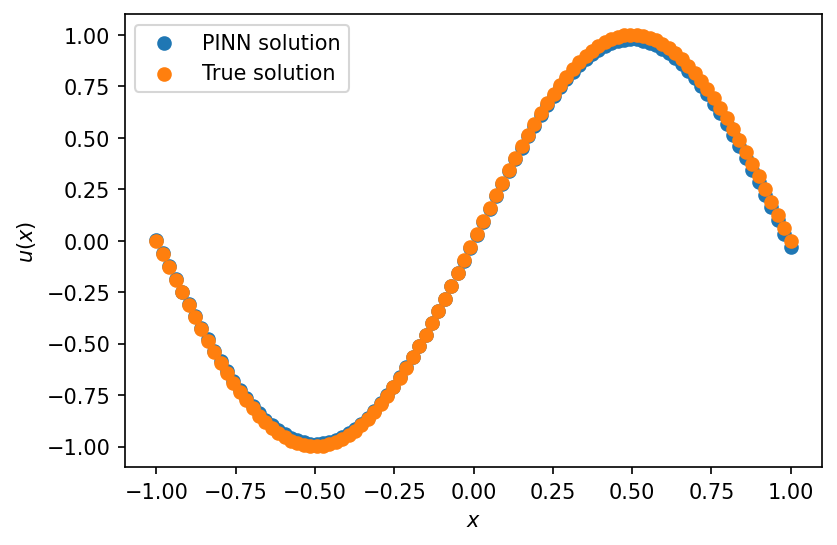

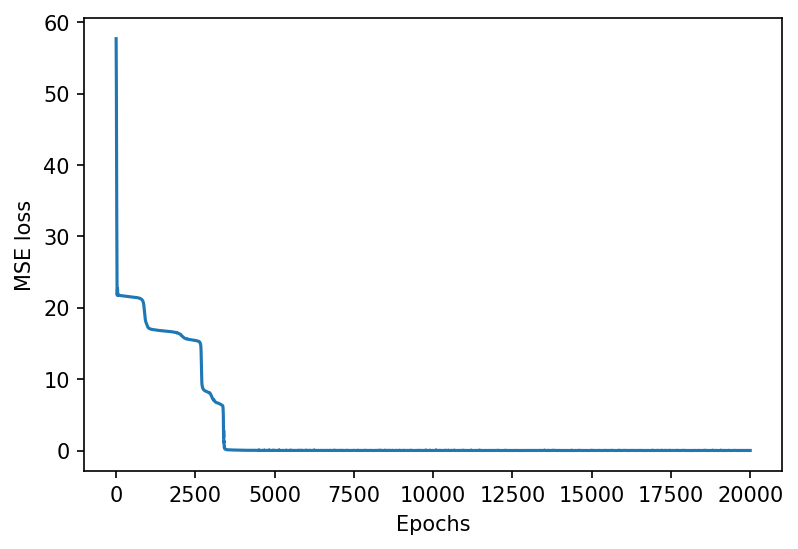

200
Epoch: 500, MSE: 22.1116
Epoch: 1000, MSE: 20.9597
Epoch: 1500, MSE: 17.9379
Epoch: 2000, MSE: 17.8931
Epoch: 2500, MSE: 17.8202
Epoch: 3000, MSE: 17.7365
Epoch: 3500, MSE: 17.4680
Epoch: 4000, MSE: 17.1919
Epoch: 4500, MSE: 16.9664
Epoch: 5000, MSE: 15.8257
Epoch: 5500, MSE: 6.5825
Epoch: 6000, MSE: 5.2247
Epoch: 6500, MSE: 0.4347
Epoch: 7000, MSE: 0.0818
Epoch: 7500, MSE: 0.0387
Epoch: 8000, MSE: 0.0620
Epoch: 8500, MSE: 0.0137
Epoch: 9000, MSE: 0.0194
Epoch: 9500, MSE: 0.0083
Epoch: 10000, MSE: 0.0066
Epoch: 10500, MSE: 0.0363
Epoch: 11000, MSE: 0.0063
Epoch: 11500, MSE: 0.0181
Epoch: 12000, MSE: 0.0044
Epoch: 12500, MSE: 0.0042
Epoch: 13000, MSE: 0.0038
Epoch: 13500, MSE: 0.0040
Epoch: 14000, MSE: 0.0441
Epoch: 14500, MSE: 0.0038
Epoch: 15000, MSE: 0.0029
Epoch: 15500, MSE: 0.0027
Epoch: 16000, MSE: 0.0025
Epoch: 16500, MSE: 0.0032
Epoch: 17000, MSE: 0.0022
Epoch: 17500, MSE: 0.0105
Epoch: 18000, MSE: 0.0019
Epoch: 18500, MSE: 0.0018
Epoch: 19000, MSE: 0.0019
Epoch: 19500, MSE:

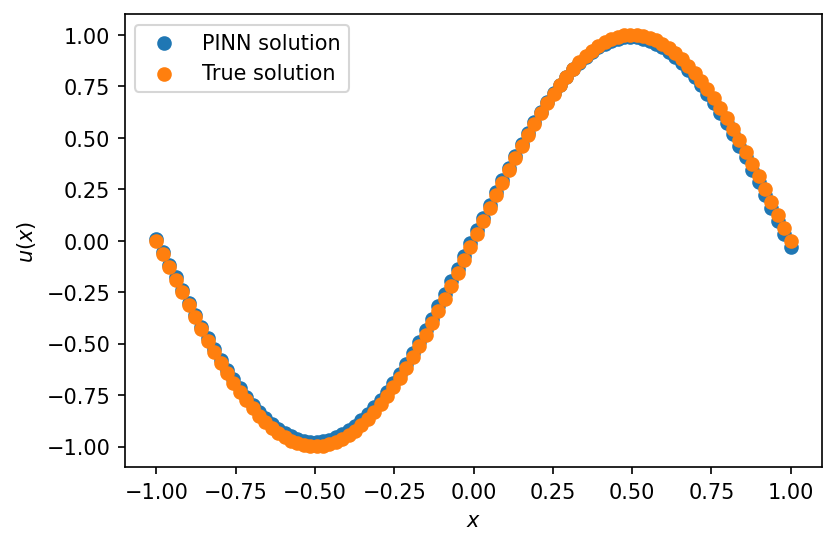

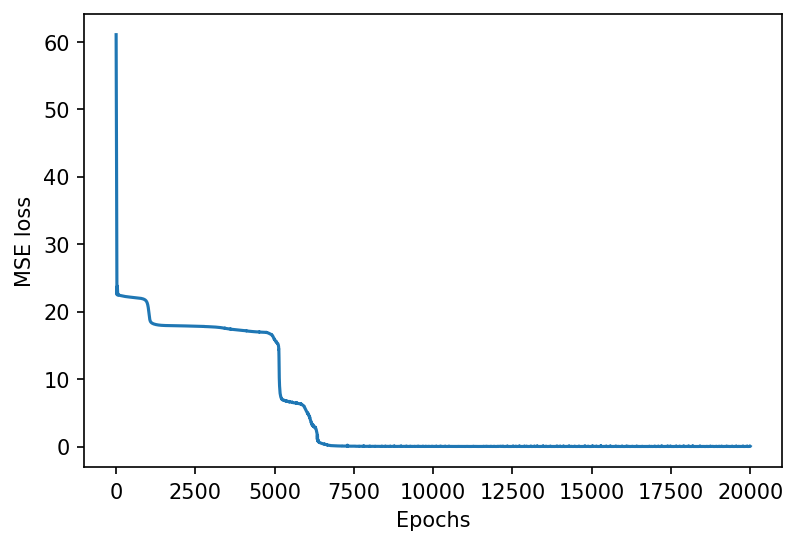

300
Epoch: 500, MSE: 23.2597
Epoch: 1000, MSE: 18.7826
Epoch: 1500, MSE: 18.4827
Epoch: 2000, MSE: 18.1560
Epoch: 2500, MSE: 18.0518
Epoch: 3000, MSE: 18.0395
Epoch: 3500, MSE: 18.0275
Epoch: 4000, MSE: 18.0043
Epoch: 4500, MSE: 17.9278
Epoch: 5000, MSE: 17.7942
Epoch: 5500, MSE: 17.7299
Epoch: 6000, MSE: 17.6853
Epoch: 6500, MSE: 17.4983
Epoch: 7000, MSE: 17.3874
Epoch: 7500, MSE: 17.2501
Epoch: 8000, MSE: 17.1509
Epoch: 8500, MSE: 16.5152
Epoch: 9000, MSE: 6.7930
Epoch: 9500, MSE: 6.6863
Epoch: 10000, MSE: 2.9000
Epoch: 10500, MSE: 2.8335
Epoch: 11000, MSE: 2.7743
Epoch: 11500, MSE: 2.6985
Epoch: 12000, MSE: 2.5825
Epoch: 12500, MSE: 2.2461
Epoch: 13000, MSE: 1.0614
Epoch: 13500, MSE: 0.4108
Epoch: 14000, MSE: 0.3614
Epoch: 14500, MSE: 0.1323
Epoch: 15000, MSE: 0.0673
Epoch: 15500, MSE: 0.0485
Epoch: 16000, MSE: 0.0277
Epoch: 16500, MSE: 0.0175
Epoch: 17000, MSE: 0.0227
Epoch: 17500, MSE: 0.0103
Epoch: 18000, MSE: 0.0060
Epoch: 18500, MSE: 0.0053
Epoch: 19000, MSE: 0.0038
Epoch: 1950

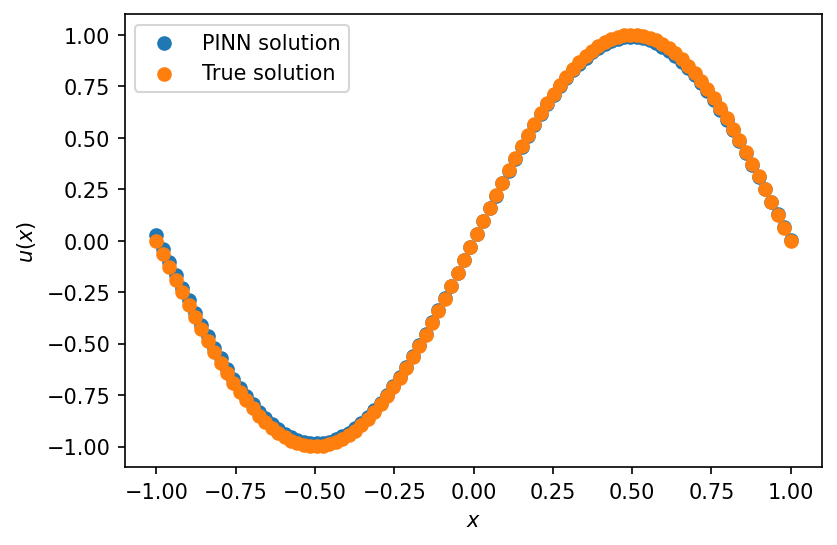

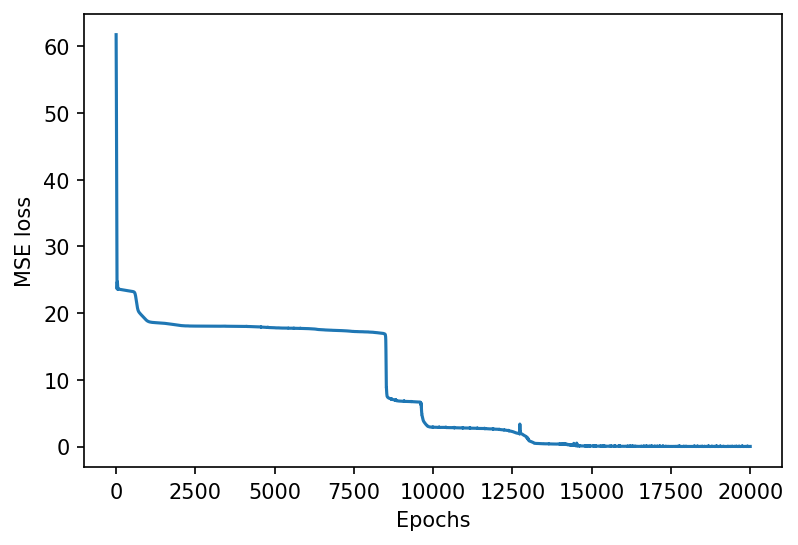

400
Epoch: 500, MSE: 21.6547
Epoch: 1000, MSE: 21.5685
Epoch: 1500, MSE: 19.4488
Epoch: 2000, MSE: 19.0290
Epoch: 2500, MSE: 18.0406
Epoch: 3000, MSE: 17.4745
Epoch: 3500, MSE: 16.9433
Epoch: 4000, MSE: 16.7624
Epoch: 4500, MSE: 16.7098
Epoch: 5000, MSE: 16.7011
Epoch: 5500, MSE: 16.6978
Epoch: 6000, MSE: 16.6943
Epoch: 6500, MSE: 16.6837
Epoch: 7000, MSE: 16.6507
Epoch: 7500, MSE: 16.6222
Epoch: 8000, MSE: 16.5969
Epoch: 8500, MSE: 16.5546
Epoch: 9000, MSE: 16.5212
Epoch: 9500, MSE: 16.5094
Epoch: 10000, MSE: 16.4882
Epoch: 10500, MSE: 16.3378
Epoch: 11000, MSE: 16.3028
Epoch: 11500, MSE: 0.0229
Epoch: 12000, MSE: 0.0088
Epoch: 12500, MSE: 0.0056
Epoch: 13000, MSE: 0.0039
Epoch: 13500, MSE: 0.0042
Epoch: 14000, MSE: 0.0020
Epoch: 14500, MSE: 0.0020
Epoch: 15000, MSE: 0.0302
Epoch: 15500, MSE: 0.0017
Epoch: 16000, MSE: 0.0017
Epoch: 16500, MSE: 0.0014
Epoch: 17000, MSE: 0.0075
Epoch: 17500, MSE: 0.0013
Epoch: 18000, MSE: 0.0012
Epoch: 18500, MSE: 0.0012
Epoch: 19000, MSE: 0.0011
Epoch:

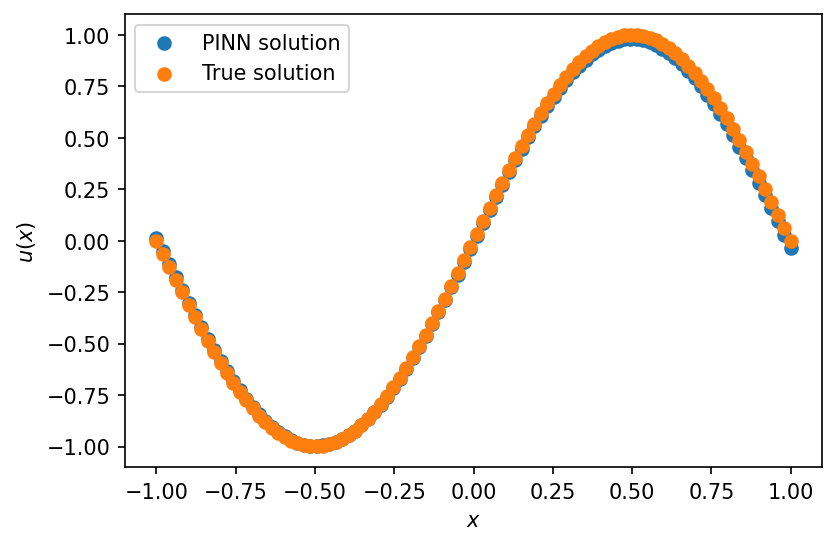

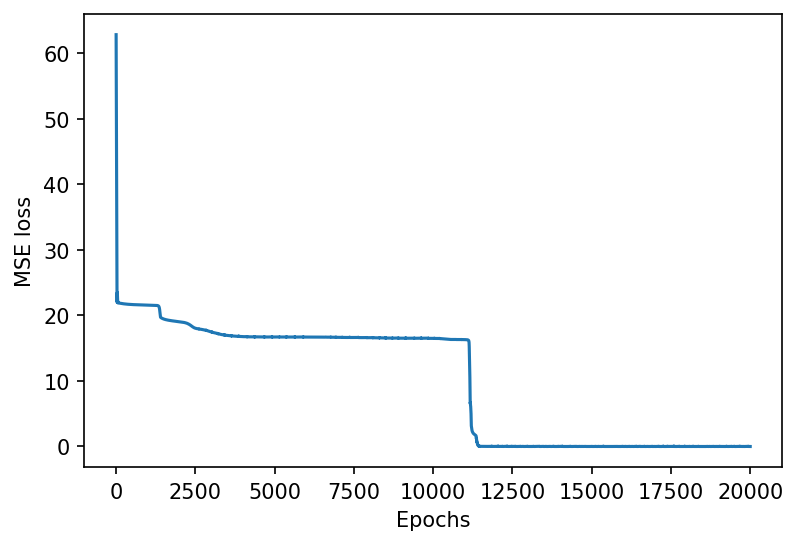

500
Epoch: 500, MSE: 20.8755
Epoch: 1000, MSE: 17.7887
Epoch: 1500, MSE: 17.3517
Epoch: 2000, MSE: 16.9901
Epoch: 2500, MSE: 16.8011
Epoch: 3000, MSE: 16.7502
Epoch: 3500, MSE: 16.7434
Epoch: 4000, MSE: 16.7389
Epoch: 4500, MSE: 16.7361
Epoch: 5000, MSE: 16.7315
Epoch: 5500, MSE: 16.6856
Epoch: 6000, MSE: 16.6675
Epoch: 6500, MSE: 16.6422
Epoch: 7000, MSE: 16.5761
Epoch: 7500, MSE: 16.1232
Epoch: 8000, MSE: 15.8676
Epoch: 8500, MSE: 0.0210
Epoch: 9000, MSE: 0.0077
Epoch: 9500, MSE: 0.0043
Epoch: 10000, MSE: 0.0035
Epoch: 10500, MSE: 0.0030
Epoch: 11000, MSE: 0.0028
Epoch: 11500, MSE: 0.0027
Epoch: 12000, MSE: 0.0029
Epoch: 12500, MSE: 0.0119
Epoch: 13000, MSE: 0.0023
Epoch: 13500, MSE: 0.0022
Epoch: 14000, MSE: 0.0023
Epoch: 14500, MSE: 0.0019
Epoch: 15000, MSE: 0.0018
Epoch: 15500, MSE: 0.0038
Epoch: 16000, MSE: 0.0015
Epoch: 16500, MSE: 0.0014
Epoch: 17000, MSE: 0.0025
Epoch: 17500, MSE: 0.0014
Epoch: 18000, MSE: 0.0012
Epoch: 18500, MSE: 0.0010
Epoch: 19000, MSE: 0.0010
Epoch: 19500

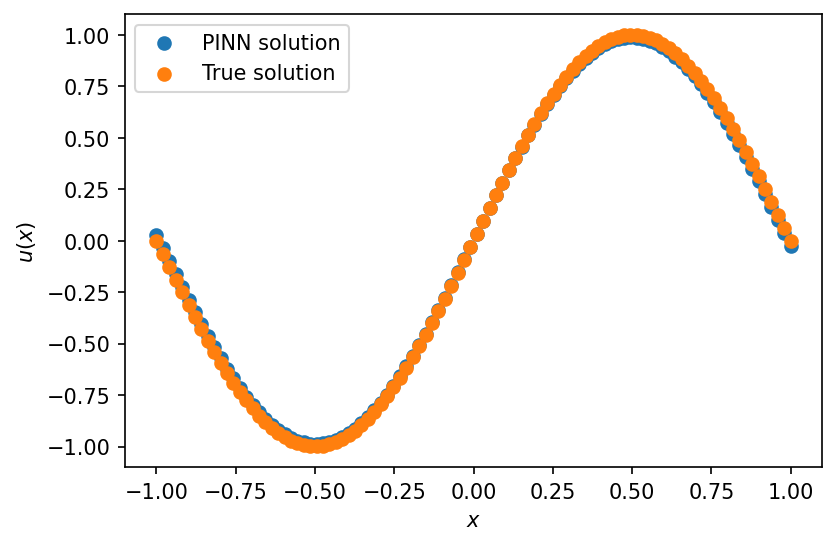

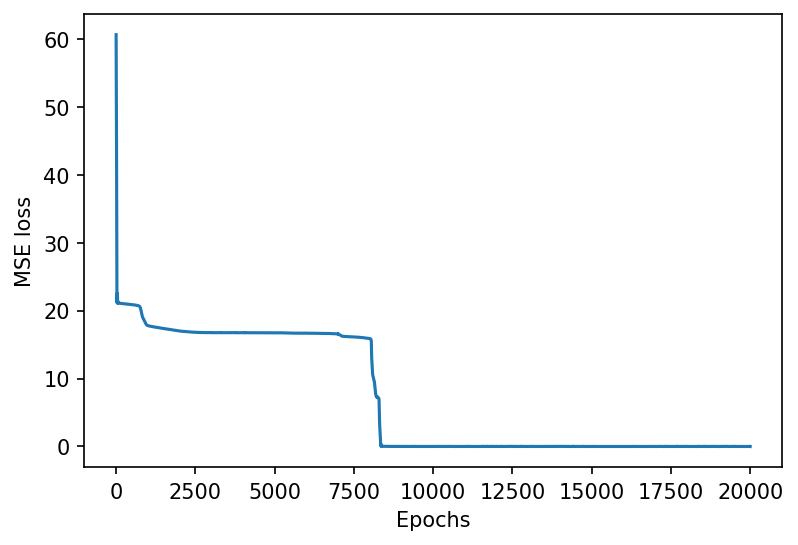

600
Epoch: 500, MSE: 21.6415
Epoch: 1000, MSE: 21.4946
Epoch: 1500, MSE: 18.2097
Epoch: 2000, MSE: 17.9668
Epoch: 2500, MSE: 17.8088
Epoch: 3000, MSE: 17.6490
Epoch: 3500, MSE: 17.5053
Epoch: 4000, MSE: 17.4147
Epoch: 4500, MSE: 17.3912
Epoch: 5000, MSE: 17.3836
Epoch: 5500, MSE: 17.3775
Epoch: 6000, MSE: 17.3533
Epoch: 6500, MSE: 17.2675
Epoch: 7000, MSE: 17.2412
Epoch: 7500, MSE: 17.2270
Epoch: 8000, MSE: 17.1996
Epoch: 8500, MSE: 6.8340
Epoch: 9000, MSE: 6.5941
Epoch: 9500, MSE: 6.5769
Epoch: 10000, MSE: 6.5778
Epoch: 10500, MSE: 6.5662
Epoch: 11000, MSE: 6.5604
Epoch: 11500, MSE: 0.0201
Epoch: 12000, MSE: 0.0043
Epoch: 12500, MSE: 0.0023
Epoch: 13000, MSE: 0.0018
Epoch: 13500, MSE: 0.0096
Epoch: 14000, MSE: 0.0010
Epoch: 14500, MSE: 0.0018
Epoch: 15000, MSE: 0.0012
Epoch: 15500, MSE: 0.0008
Epoch: 16000, MSE: 0.0006
Epoch: 16500, MSE: 0.0005
Epoch: 17000, MSE: 0.0059
Epoch: 17500, MSE: 0.0005
Epoch: 18000, MSE: 0.0005
Epoch: 18500, MSE: 0.0017
Epoch: 19000, MSE: 0.0012
Epoch: 19500

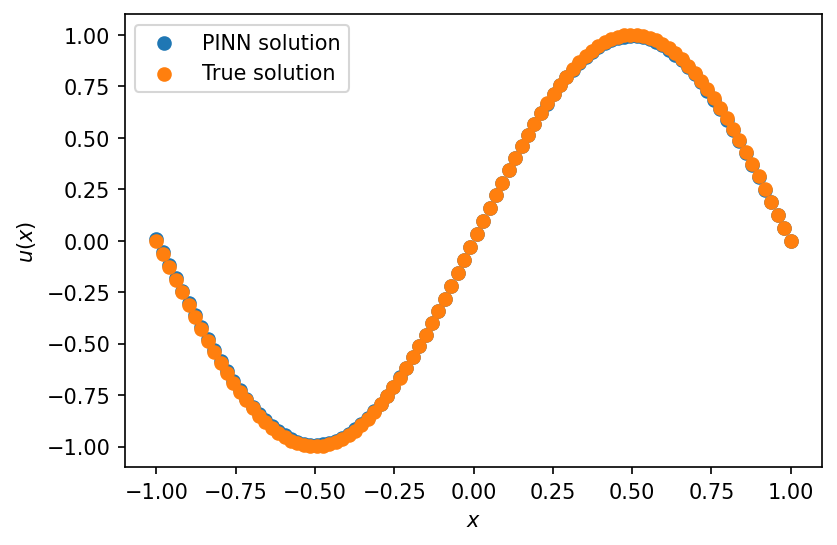

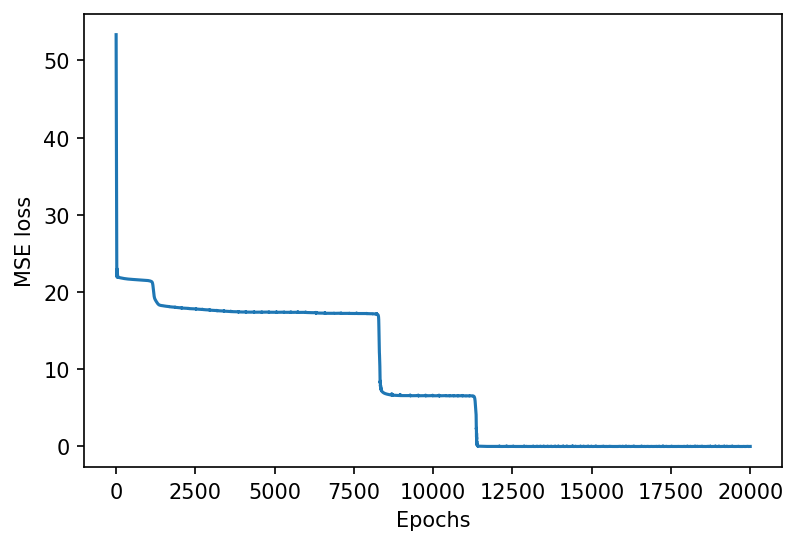

700
Epoch: 500, MSE: 22.5338
Epoch: 1000, MSE: 22.4605
Epoch: 1500, MSE: 22.4140
Epoch: 2000, MSE: 22.2310
Epoch: 2500, MSE: 18.6819
Epoch: 3000, MSE: 18.4157
Epoch: 3500, MSE: 18.3196
Epoch: 4000, MSE: 18.2690
Epoch: 4500, MSE: 18.0780
Epoch: 5000, MSE: 17.8986
Epoch: 5500, MSE: 17.8236
Epoch: 6000, MSE: 17.7838
Epoch: 6500, MSE: 17.7484
Epoch: 7000, MSE: 17.7080
Epoch: 7500, MSE: 17.6148
Epoch: 8000, MSE: 17.5272
Epoch: 8500, MSE: 17.5013
Epoch: 9000, MSE: 17.4944
Epoch: 9500, MSE: 17.4915
Epoch: 10000, MSE: 17.4895
Epoch: 10500, MSE: 17.4875
Epoch: 11000, MSE: 17.4842
Epoch: 11500, MSE: 17.4781
Epoch: 12000, MSE: 17.4529
Epoch: 12500, MSE: 17.4015
Epoch: 13000, MSE: 17.3676
Epoch: 13500, MSE: 17.3542
Epoch: 14000, MSE: 17.3286
Epoch: 14500, MSE: 17.2871
Epoch: 15000, MSE: 17.2946
Epoch: 15500, MSE: 17.2112
Epoch: 16000, MSE: 0.1177
Epoch: 16500, MSE: 0.0956
Epoch: 17000, MSE: 0.0130
Epoch: 17500, MSE: 0.0117
Epoch: 18000, MSE: 0.0087
Epoch: 18500, MSE: 0.0078
Epoch: 19000, MSE: 0.00

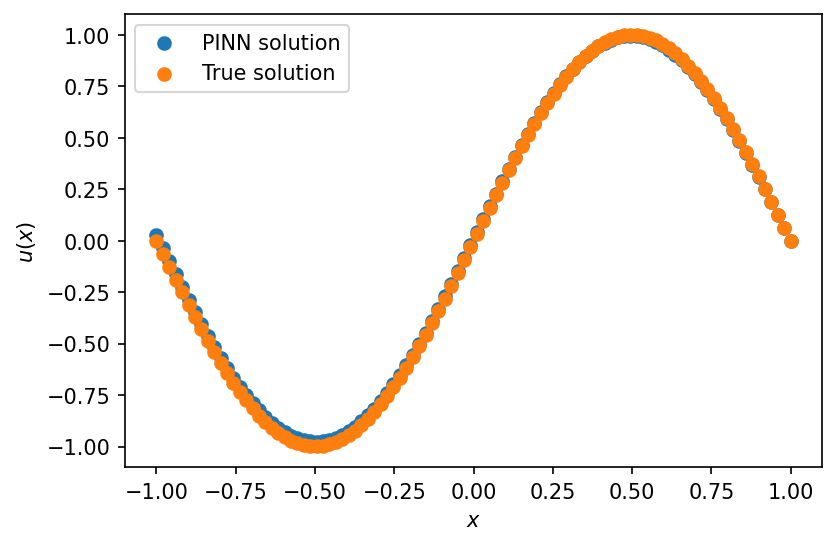

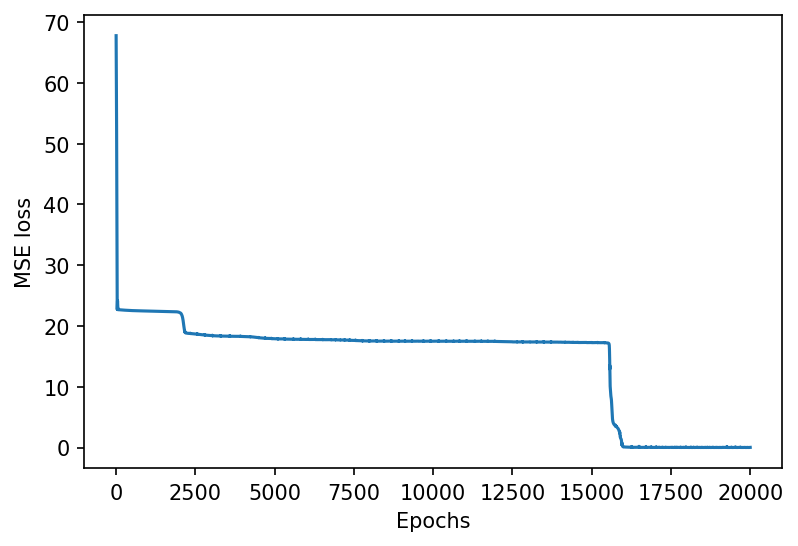

800
Epoch: 500, MSE: 23.8972
Epoch: 1000, MSE: 23.8077
Epoch: 1500, MSE: 23.7231
Epoch: 2000, MSE: 19.1663
Epoch: 2500, MSE: 19.0854
Epoch: 3000, MSE: 19.0579
Epoch: 3500, MSE: 19.0383
Epoch: 4000, MSE: 18.9753
Epoch: 4500, MSE: 18.6669
Epoch: 5000, MSE: 18.5968
Epoch: 5500, MSE: 18.5423
Epoch: 6000, MSE: 18.5382
Epoch: 6500, MSE: 18.5357
Epoch: 7000, MSE: 18.5396
Epoch: 7500, MSE: 18.5314
Epoch: 8000, MSE: 18.5281
Epoch: 8500, MSE: 18.5242
Epoch: 9000, MSE: 18.5181
Epoch: 9500, MSE: 7.8268
Epoch: 10000, MSE: 7.2471
Epoch: 10500, MSE: 7.0922
Epoch: 11000, MSE: 0.0128
Epoch: 11500, MSE: 0.0095
Epoch: 12000, MSE: 0.0079
Epoch: 12500, MSE: 0.0069
Epoch: 13000, MSE: 0.0065
Epoch: 13500, MSE: 0.0057
Epoch: 14000, MSE: 0.0053
Epoch: 14500, MSE: 0.0050
Epoch: 15000, MSE: 0.0047
Epoch: 15500, MSE: 0.0055
Epoch: 16000, MSE: 0.0051
Epoch: 16500, MSE: 0.0409
Epoch: 17000, MSE: 0.0040
Epoch: 17500, MSE: 0.0040
Epoch: 18000, MSE: 0.0039
Epoch: 18500, MSE: 0.0067
Epoch: 19000, MSE: 0.0037
Epoch: 195

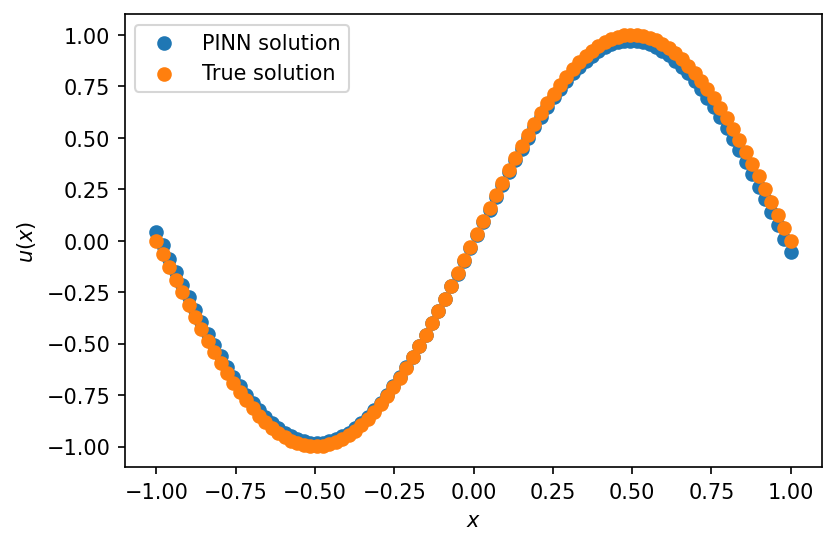

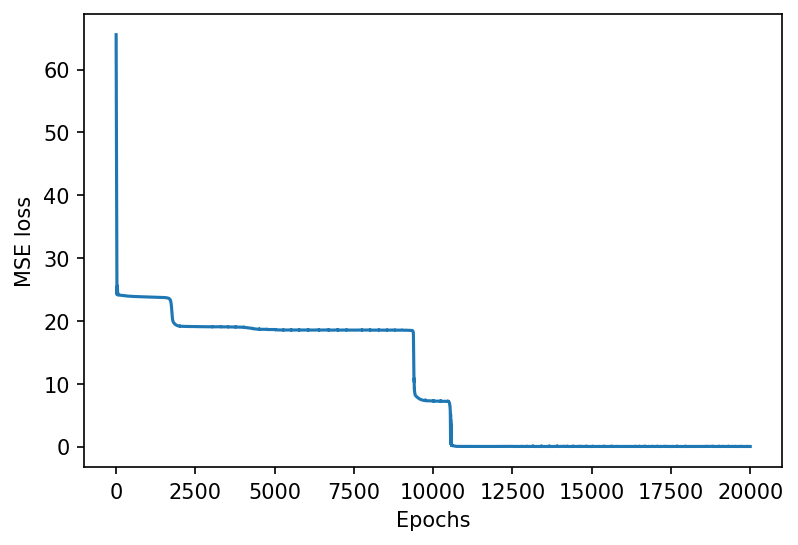

900
Epoch: 500, MSE: 23.7044
Epoch: 1000, MSE: 23.4443
Epoch: 1500, MSE: 19.1961
Epoch: 2000, MSE: 18.6676
Epoch: 2500, MSE: 18.5955
Epoch: 3000, MSE: 18.5754
Epoch: 3500, MSE: 18.5546
Epoch: 4000, MSE: 18.5259
Epoch: 4500, MSE: 18.4830
Epoch: 5000, MSE: 18.4627
Epoch: 5500, MSE: 18.3568
Epoch: 6000, MSE: 18.1078
Epoch: 6500, MSE: 18.0899
Epoch: 7000, MSE: 18.0549
Epoch: 7500, MSE: 17.9510
Epoch: 8000, MSE: 17.8922
Epoch: 8500, MSE: 17.8619
Epoch: 9000, MSE: 17.8269
Epoch: 9500, MSE: 17.7665
Epoch: 10000, MSE: 17.6917
Epoch: 10500, MSE: 17.5615
Epoch: 11000, MSE: 17.1576
Epoch: 11500, MSE: 17.0293
Epoch: 12000, MSE: 16.7234
Epoch: 12500, MSE: 15.8058
Epoch: 13000, MSE: 13.2620
Epoch: 13500, MSE: 12.3710
Epoch: 14000, MSE: 11.5958
Epoch: 14500, MSE: 10.9950
Epoch: 15000, MSE: 10.7801
Epoch: 15500, MSE: 10.5066
Epoch: 16000, MSE: 10.2198
Epoch: 16500, MSE: 9.9663
Epoch: 17000, MSE: 9.9197
Epoch: 17500, MSE: 8.7287
Epoch: 18000, MSE: 0.3120
Epoch: 18500, MSE: 0.1987
Epoch: 19000, MSE: 0.1

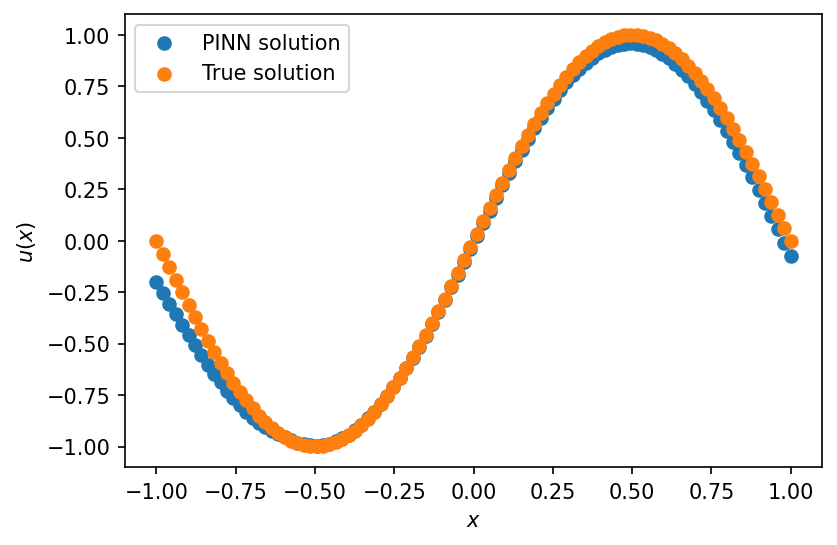

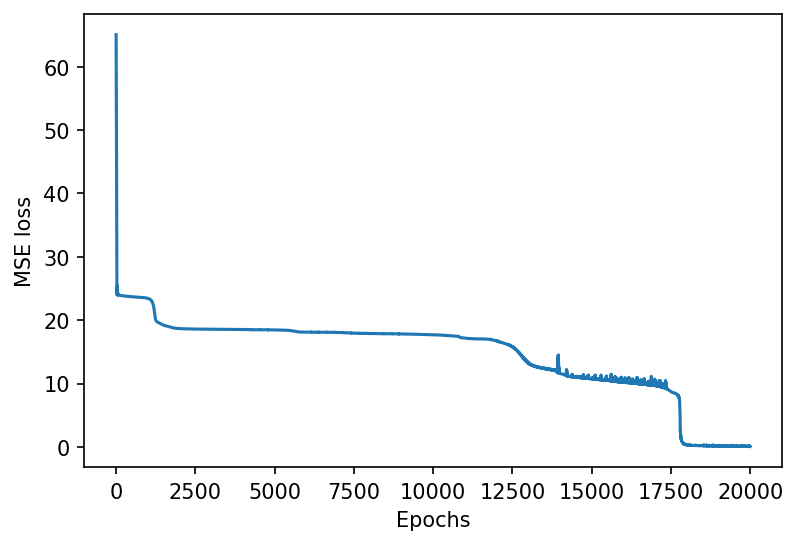

In [7]:
epochs = 20000
lr = 0.001
numSamplesVSloss = []
for num_samples in range(100,1000,100):
    print(num_samples)
    pdeObject = pdeTrainClass(num_samples)
    loss = pdeObject.train(epochs = epochs, lr = lr)
    numSamplesVSloss.append([num_samples, loss[-1][1]])
    pdeObject.plots()
    plt.show()

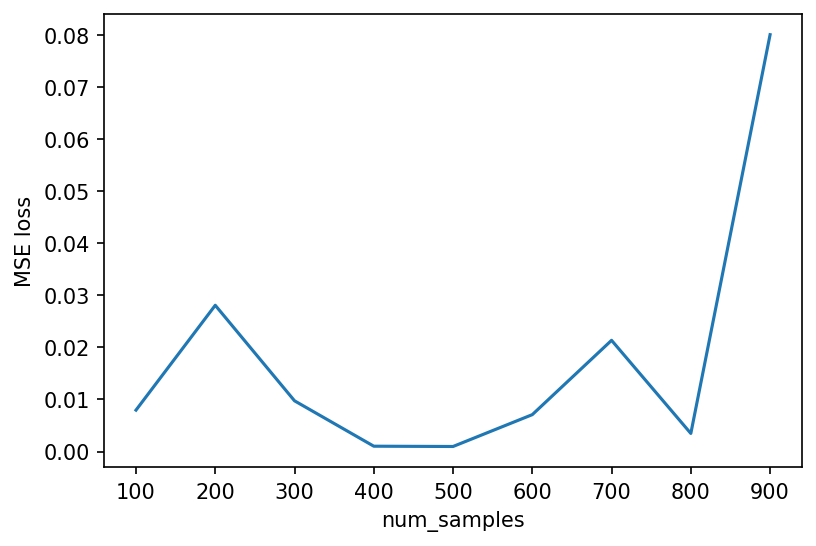

In [8]:
X = np.array(numSamplesVSloss)
plt.figure(dpi=150)
plt.plot(X[:,0], X[:,1])
plt.xlabel('num_samples')
plt.ylabel('MSE loss')
plt.savefig("numsamples_vs_Loss_{}.png".format(epochs))